# 02: The Attention Mechanism

Welcome to one of the most important ideas in modern AI! The attention mechanism, introduced in the landmark paper **"Attention Is All You Need"** (Vaswani et al., 2017), revolutionized how we process sequential data.

## What You'll Learn

By the end of this notebook, you'll understand:

1. **Why attention?** - What problems does it solve that RNNs couldn't?
2. **The core idea** - Attention as selective focus and weighted averaging
3. **Scaled dot-product attention** - The standard formulation
4. **Query, Key, Value** - The three vectors that make attention work
5. **Self-attention** - How words attend to each other
6. **Attention masks** - Controlling what can attend to what
7. **Multi-head attention** - Parallel attention in different subspaces
8. **Implementation** - Build it all from scratch in NumPy!

## Why This Matters

Attention is the **foundation of**:
- **Transformers** (GPT, BERT, T5, etc.)
- **Modern NLP** (ChatGPT, Claude, Gemini)
- **Vision models** (Vision Transformers)
- **Multimodal AI** (CLIP, DALL-E)
- **Basically everything in modern AI!**

## Learning Approach

We'll build up from first principles:
1. Start with simple intuition
2. Implement each concept step by step
3. Visualize everything
4. Connect to the big picture

Let's dive in! 🚀

---

# Setup

In [2]:
# Import libraries
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML, display

# Add utilities to path
sys.path.append(os.path.abspath('../src'))
from utils import set_style

# Set visual style
set_style()

# Set random seed
np.random.seed(42)

print("✓ Setup complete! Ready to learn about attention.")

✓ Setup complete! Ready to learn about attention.


---

# Part 1: Why Do We Need Attention?

## The Problems with RNNs (Recap)

From the previous notebook, we identified four fundamental problems:

### Problem 1: Sequential Processing
```
RNN must process words one by one:
  word₁ → word₂ → word₃ → word₄
  (can't parallelize, slow on GPUs)
```

### Problem 2: Information Bottleneck
```
In seq2seq, entire input compressed to fixed-size vector:
  100 words → [fixed 512-dim vector] → translation
  (information loss for long sequences)
```

### Problem 3: Long-Range Dependencies
```
To connect word₁ to word₅₀:
  Information flows through 49 intermediate steps
  word₁ → word₂ → ... → word₄₉ → word₅₀
  (gradients vanish, information degrades)
```

### Problem 4: No Selective Focus
```
RNN treats all previous words equally:
  Can't say "focus on word₃ and word₁₀, ignore the rest"
  (no mechanism for selective attention)
```

## The Key Insight

**What if each word could directly "look at" all other words and decide which ones are relevant?**

This is exactly what **attention** does!

## A Concrete Example: Machine Translation

Let's see why attention is crucial with a real example.

**Task**: Translate English to French

```
English: "The cat sat on the mat"
French:  "Le  chat assis sur le tapis"
```

### Without Attention (RNN Seq2Seq)

```
Encoder:
  "The" → h₁
  "cat" → h₂  
  "sat" → h₃
  "on"  → h₄
  "the" → h₅
  "mat" → h₆  (final hidden state = context vector)

Decoder:
  h₆ → "Le"     (only sees h₆)
  h₆ → "chat"   (only sees h₆)
  h₆ → "assis"  (only sees h₆)
  ...
```

**Problem**: When generating "chat" (cat), the decoder only sees h₆, which contains information about ALL English words compressed together. It can't directly look back at "cat"!

### With Attention

```
Encoder:
  "The" → h₁
  "cat" → h₂
  "sat" → h₃
  "on"  → h₄
  "the" → h₅
  "mat" → h₆

Decoder:
  Generating "Le":
    Look at all [h₁, h₂, h₃, h₄, h₅, h₆]
    Focus on h₁ ("The") ← most relevant!
    
  Generating "chat":
    Look at all [h₁, h₂, h₃, h₄, h₅, h₆]
    Focus on h₂ ("cat") ← most relevant!
    
  Generating "assis":
    Look at all [h₁, h₂, h₃, h₄, h₅, h₆]
    Focus on h₃ ("sat") ← most relevant!
```

**Key difference**: Attention lets each output word **directly access** all input words and **decide** which ones matter most!

Let's visualize this.

/var/folders/rg/q149fzx17hbck29h_fn4xgpc0000gn/T/ipykernel_65607/309037265.py:77: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/rg/q149fzx17hbck29h_fn4xgpc0000gn/T/ipykernel_65607/309037265.py:77: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/Users/chaitanya/Development/ai-learning/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/chaitanya/Development/ai-learning/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


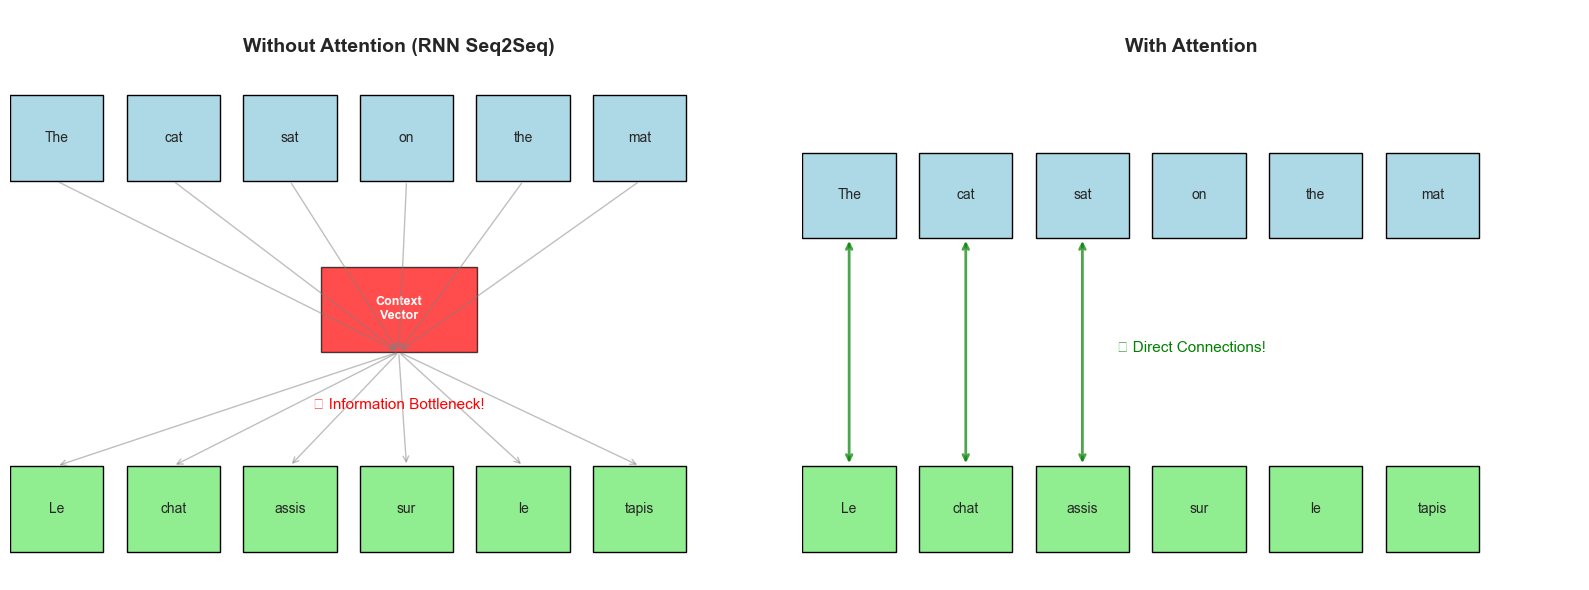


💡 Key Insight:
Attention allows DIRECT connections between any input and any output!
No bottleneck, no information loss, no long chains.


In [3]:
# Visualize attention concept
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# LEFT: Without attention (bottleneck)
ax = axes[0]
ax.text(0.5, 0.95, 'Without Attention (RNN Seq2Seq)', 
        ha='center', va='top', fontsize=14, fontweight='bold',
        transform=ax.transAxes)

# English words
english_words = ['The', 'cat', 'sat', 'on', 'the', 'mat']
for i, word in enumerate(english_words):
    ax.add_patch(plt.Rectangle((i*0.15, 0.7), 0.12, 0.15, 
                                facecolor='lightblue', edgecolor='black'))
    ax.text(i*0.15 + 0.06, 0.775, word, ha='center', va='center', fontsize=10)

# Bottleneck (context vector)
ax.add_patch(plt.Rectangle((0.4, 0.4), 0.2, 0.15, 
                            facecolor='red', edgecolor='black', alpha=0.7))
ax.text(0.5, 0.475, 'Context\nVector', ha='center', va='center', 
        fontsize=9, fontweight='bold', color='white')

# Arrows to bottleneck
for i in range(len(english_words)):
    ax.annotate('', xy=(0.5, 0.4), xytext=(i*0.15 + 0.06, 0.7),
                arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5))

# French words
french_words = ['Le', 'chat', 'assis', 'sur', 'le', 'tapis']
for i, word in enumerate(french_words):
    ax.add_patch(plt.Rectangle((i*0.15, 0.05), 0.12, 0.15, 
                                facecolor='lightgreen', edgecolor='black'))
    ax.text(i*0.15 + 0.06, 0.125, word, ha='center', va='center', fontsize=10)

# Arrows from bottleneck
for i in range(len(french_words)):
    ax.annotate('', xy=(i*0.15 + 0.06, 0.2), xytext=(0.5, 0.4),
                arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5))

ax.text(0.5, 0.3, '❌ Information Bottleneck!', ha='center', fontsize=11, color='red')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')

# RIGHT: With attention
ax = axes[1]
ax.text(0.5, 0.95, 'With Attention', 
        ha='center', va='top', fontsize=14, fontweight='bold',
        transform=ax.transAxes)

# English words
for i, word in enumerate(english_words):
    ax.add_patch(plt.Rectangle((i*0.15, 0.6), 0.12, 0.15, 
                                facecolor='lightblue', edgecolor='black'))
    ax.text(i*0.15 + 0.06, 0.675, word, ha='center', va='center', fontsize=10)

# French words
for i, word in enumerate(french_words):
    ax.add_patch(plt.Rectangle((i*0.15, 0.05), 0.12, 0.15, 
                                facecolor='lightgreen', edgecolor='black'))
    ax.text(i*0.15 + 0.06, 0.125, word, ha='center', va='center', fontsize=10)

# Direct attention connections (example: "chat" attending to "cat")
# Show alignment: Le→The, chat→cat, assis→sat
alignments = [(0, 0), (1, 1), (2, 2)]  # (french_idx, english_idx)
for fr_idx, en_idx in alignments:
    ax.annotate('', 
                xy=(en_idx*0.15 + 0.06, 0.6), 
                xytext=(fr_idx*0.15 + 0.06, 0.2),
                arrowprops=dict(arrowstyle='<->', color='green', lw=2, alpha=0.7))

ax.text(0.5, 0.4, '✓ Direct Connections!', ha='center', fontsize=11, color='green')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')

plt.tight_layout()
plt.show()

print("\n💡 Key Insight:")
print("Attention allows DIRECT connections between any input and any output!")
print("No bottleneck, no information loss, no long chains.")

## How Attention Solves the Four Problems

Let's see how attention addresses each RNN limitation:

| Problem | RNN Approach | Attention Solution |
|---------|--------------|--------------------|
| **Sequential Processing** | Must process word₁ before word₂ | All words processed in parallel ✓ |
| **Information Bottleneck** | Fixed-size context vector | Direct access to all inputs ✓ |
| **Long-Range Dependencies** | Info flows through chain | Direct connections ✓ |
| **No Selective Focus** | Treats all words equally | Computes relevance weights ✓ |

**Result**: Attention is faster, more flexible, and more powerful!

Now let's understand **how** it works.

---

# Part 2: Attention as Weighted Averaging

## The Core Idea (Simple Intuition)

**Attention is fundamentally about computing a weighted average.**

Think of it like this:

You're at a party with 5 friends talking. At any moment:
- You pay **100% attention** to one friend (weight = 1.0)
- Or **split attention** across multiple friends (weights sum to 1.0)
- Or **ignore** some friends (weight = 0.0)

**Attention mechanism does exactly this with words!**

## A Simple Example

Let's build intuition with a concrete example.

**Scenario**: We have 3 words, each represented as a vector:

```
word₁ = [1, 0, 0]  ("cat")
word₂ = [0, 1, 0]  ("sat")
word₃ = [0, 0, 1]  ("mat")
```

**Question**: What if we want to focus on "cat" and "mat" but ignore "sat"?

**Answer**: Use weights!

```
weights = [0.7, 0.0, 0.3]  (70% cat, 0% sat, 30% mat)

attention_output = 0.7 * word₁ + 0.0 * word₂ + 0.3 * word₃
                 = 0.7 * [1,0,0] + 0.0 * [0,1,0] + 0.3 * [0,0,1]
                 = [0.7, 0.0, 0.3]
```

**This is attention!** A weighted combination of inputs based on relevance.

Let's implement this.

In [4]:
# Simple attention: weighted averaging

# Input: 3 words as vectors
words = np.array([
    [1, 0, 0],  # word 1: "cat"
    [0, 1, 0],  # word 2: "sat" 
    [0, 0, 1],  # word 3: "mat"
])

print("Input words (3 words × 3 dimensions):")
print(words)
print()

# Attention weights (how much to focus on each word)
weights = np.array([0.7, 0.0, 0.3])

print("Attention weights:")
print(f"  word 1 ('cat'): {weights[0]:.1f}")
print(f"  word 2 ('sat'): {weights[1]:.1f}")
print(f"  word 3 ('mat'): {weights[2]:.1f}")
print(f"  Sum: {weights.sum():.1f} (must equal 1.0)")
print()

# Compute attention output (weighted average)
attention_output = weights @ words  # Matrix multiplication does the weighted sum!

print("Attention output:")
print(attention_output)
print()
print("Interpretation:")
print(f"  Output is {weights[0]*100:.0f}% of word 1 + {weights[2]*100:.0f}% of word 3")
print(f"  Word 2 is ignored (weight = 0)")

Input words (3 words × 3 dimensions):
[[1 0 0]
 [0 1 0]
 [0 0 1]]

Attention weights:
  word 1 ('cat'): 0.7
  word 2 ('sat'): 0.0
  word 3 ('mat'): 0.3
  Sum: 1.0 (must equal 1.0)

Attention output:
[0.7 0.  0.3]

Interpretation:
  Output is 70% of word 1 + 30% of word 3
  Word 2 is ignored (weight = 0)


### Visualizing Weighted Averaging

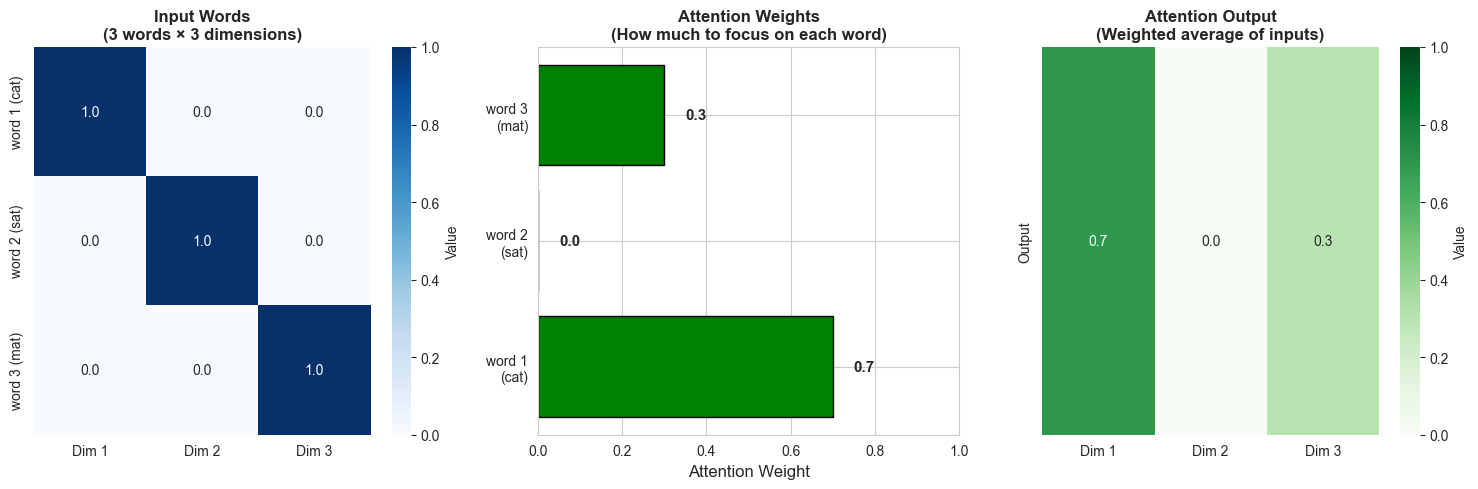


💡 The Magic Formula:
   output = Σ (weight_i × word_i)
   output = weighted average of all input words


In [5]:
# Visualize the weighted averaging process
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# LEFT: Input words
ax = axes[0]
sns.heatmap(words, annot=True, fmt='.1f', cmap='Blues', 
            xticklabels=['Dim 1', 'Dim 2', 'Dim 3'],
            yticklabels=['word 1 (cat)', 'word 2 (sat)', 'word 3 (mat)'],
            cbar_kws={'label': 'Value'}, ax=ax, vmin=0, vmax=1)
ax.set_title('Input Words\n(3 words × 3 dimensions)', fontweight='bold')

# MIDDLE: Attention weights
ax = axes[1]
colors = ['green' if w > 0 else 'lightgray' for w in weights]
ax.barh(['word 1\n(cat)', 'word 2\n(sat)', 'word 3\n(mat)'], weights, color=colors, edgecolor='black')
ax.set_xlabel('Attention Weight', fontsize=12)
ax.set_title('Attention Weights\n(How much to focus on each word)', fontweight='bold')
ax.set_xlim([0, 1])
for i, w in enumerate(weights):
    ax.text(w + 0.05, i, f'{w:.1f}', va='center', fontsize=11, fontweight='bold')

# RIGHT: Output
ax = axes[2]
output_matrix = attention_output.reshape(-1, 1).T
sns.heatmap(output_matrix, annot=True, fmt='.1f', cmap='Greens',
            xticklabels=['Dim 1', 'Dim 2', 'Dim 3'],
            yticklabels=['Output'],
            cbar_kws={'label': 'Value'}, ax=ax, vmin=0, vmax=1)
ax.set_title('Attention Output\n(Weighted average of inputs)', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n💡 The Magic Formula:")
print("   output = Σ (weight_i × word_i)")
print("   output = weighted average of all input words")

## The Key Question

**We now know HOW to compute attention (weighted average).**

**But how do we get the weights?**

We can't manually set them - we need an automatic way to compute:
- Which words are relevant?
- How much attention to pay to each?

This is where **Query, Key, Value** comes in! But first, let's understand the standard attention formula.

---

# Part 3: Scaled Dot-Product Attention

## The Standard Formulation

The attention mechanism used in transformers is called **Scaled Dot-Product Attention**.

Here's the famous equation:

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

This looks scary! Let's break it down step by step.

## Step-by-Step Breakdown

### Step 1: Compute Similarity Scores (QK^T)

**Question**: How similar is each word to every other word?

**Answer**: Compute dot products!

```
For each pair of words (i, j):
  score[i,j] = Q[i] · K[j]  (dot product)
  
High score = words are similar/relevant
Low score = words are dissimilar/irrelevant
```

### Step 2: Scale (/√d_k)

**Why?** Dot products can get very large when vectors have high dimensions.

**Fix**: Divide by √d_k (where d_k = dimension of keys)

```
scaled_scores = scores / √d_k
```

This keeps scores in a reasonable range, which helps softmax work better.

### Step 3: Convert to Probabilities (softmax)

**Goal**: Convert scores to attention weights that sum to 1.0

```
weights = softmax(scaled_scores)

For each row i:
  weights[i] = exp(scaled_scores[i]) / sum(exp(scaled_scores[i]))
```

Now we have proper probability distributions!

### Step 4: Weighted Average (weights × V)

**Finally**: Use weights to combine values

```
output = weights @ V
```

This gives us the attention output!

## Let's Implement It

In [6]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Scaled Dot-Product Attention.
    
    Args:
        Q: Queries, shape (seq_len, d_k)
        K: Keys, shape (seq_len, d_k)
        V: Values, shape (seq_len, d_v)
        mask: Optional mask, shape (seq_len, seq_len)
    
    Returns:
        output: Attention output, shape (seq_len, d_v)
        attention_weights: Attention weights, shape (seq_len, seq_len)
    """
    
    # Step 1: Compute similarity scores (Q @ K^T)
    d_k = K.shape[-1]  # Dimension of keys
    scores = Q @ K.T  # Shape: (seq_len, seq_len)
    
    print(f"Step 1: Compute scores (Q @ K^T)")
    print(f"  Q shape: {Q.shape}, K shape: {K.shape}")
    print(f"  Scores shape: {scores.shape}")
    print(f"  Scores range: [{scores.min():.2f}, {scores.max():.2f}]")
    
    # Step 2: Scale by √d_k
    scaled_scores = scores / np.sqrt(d_k)
    
    print(f"\nStep 2: Scale by √d_k = √{d_k} = {np.sqrt(d_k):.2f}")
    print(f"  Scaled scores range: [{scaled_scores.min():.2f}, {scaled_scores.max():.2f}]")
    
    # Apply mask if provided
    if mask is not None:
        scaled_scores = np.where(mask == 0, -1e9, scaled_scores)
        print(f"\nStep 2.5: Applied mask")
    
    # Step 3: Apply softmax to get attention weights
    # Softmax along the last dimension (for each query, compute weights over all keys)
    exp_scores = np.exp(scaled_scores - np.max(scaled_scores, axis=-1, keepdims=True))  # Numerical stability
    attention_weights = exp_scores / np.sum(exp_scores, axis=-1, keepdims=True)
    
    print(f"\nStep 3: Apply softmax to get weights")
    print(f"  Weights shape: {attention_weights.shape}")
    print(f"  Weights sum (per row): {attention_weights.sum(axis=-1)}")
    print(f"  (Each row sums to 1.0 ✓)")
    
    # Step 4: Weighted average of values
    output = attention_weights @ V
    
    print(f"\nStep 4: Weighted average (weights @ V)")
    print(f"  V shape: {V.shape}")
    print(f"  Output shape: {output.shape}")
    
    return output, attention_weights

print("✓ Scaled dot-product attention function defined!")

✓ Scaled dot-product attention function defined!


### Test with Simple Inputs

Let's test our attention function with simple inputs where we can verify the results.

In [7]:
# Create simple test inputs
seq_len = 3
d_k = 4  # Dimension of Q and K
d_v = 4  # Dimension of V

# For now, let's use Q = K = V (self-attention)
# We'll make them simple so we can understand what's happening
np.random.seed(42)
Q = np.random.randn(seq_len, d_k) * 0.5
K = Q.copy()  # Self-attention: use same for Q and K
V = np.eye(seq_len, d_v)  # Identity-like values for easy interpretation

print("Test inputs:")
print(f"\nQ (Queries):")
print(Q)
print(f"\nK (Keys):")
print(K)
print(f"\nV (Values):")
print(V)
print("\n" + "="*70)

# Compute attention
output, weights = scaled_dot_product_attention(Q, K, V)

print("\n" + "="*70)
print("\nFinal Results:")
print(f"\nAttention Weights:")
print(weights)
print(f"\nAttention Output:")
print(output)

Test inputs:

Q (Queries):
[[ 0.24835708 -0.06913215  0.32384427  0.76151493]
 [-0.11707669 -0.11706848  0.78960641  0.38371736]
 [-0.23473719  0.27128002 -0.23170885 -0.23286488]]

K (Keys):
[[ 0.24835708 -0.06913215  0.32384427  0.76151493]
 [-0.11707669 -0.11706848  0.78960641  0.38371736]
 [-0.23473719  0.27128002 -0.23170885 -0.23286488]]

V (Values):
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]

Step 1: Compute scores (Q @ K^T)
  Q shape: (3, 4), K shape: (3, 4)
  Scores shape: (3, 3)
  Scores range: [-0.33, 0.80]

Step 2: Scale by √d_k = √4 = 2.00
  Scaled scores range: [-0.16, 0.40]

Step 3: Apply softmax to get weights
  Weights shape: (3, 3)
  Weights sum (per row): [1. 1. 1.]
  (Each row sums to 1.0 ✓)

Step 4: Weighted average (weights @ V)
  V shape: (3, 4)
  Output shape: (3, 4)


Final Results:

Attention Weights:
[[0.40380185 0.3609611  0.23523706]
 [0.35532023 0.40692052 0.23775926]
 [0.298161   0.30614207 0.39569693]]

Attention Output:
[[0.40380185 0.3609611  0.2352

### Visualize Attention Weights

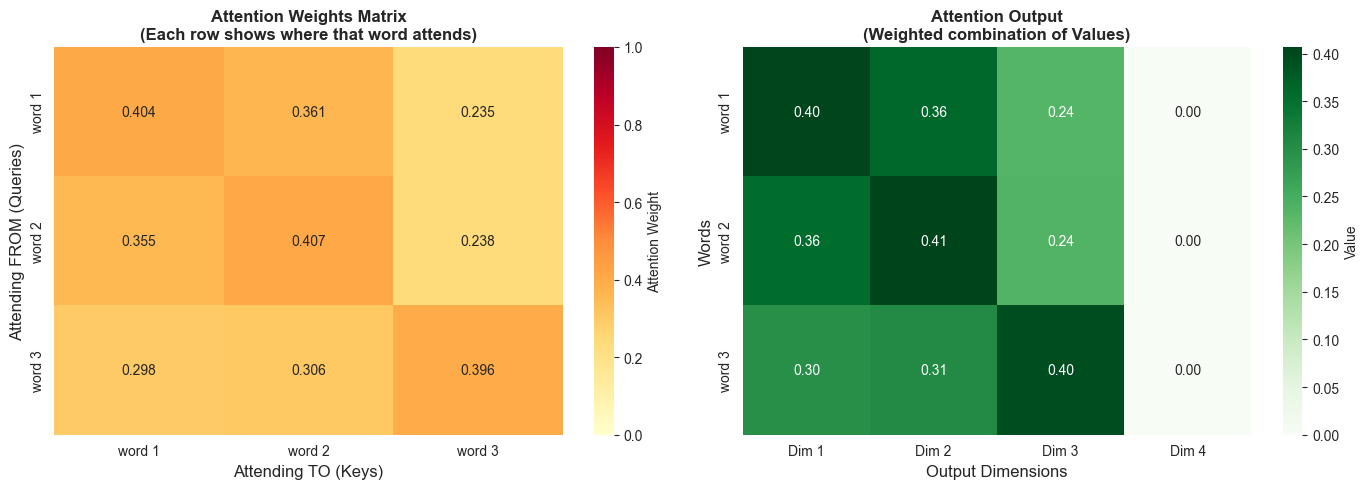


📊 Reading the Heatmap:
Left plot: Each ROW shows where that word pays attention
  Example: Row 1 attends to word 1 with weight 0.404

Right plot: Final output after weighted averaging


In [8]:
# Visualize the attention weights as a heatmap
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LEFT: Attention weights
ax = axes[0]
sns.heatmap(weights, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=['word 1', 'word 2', 'word 3'],
            yticklabels=['word 1', 'word 2', 'word 3'],
            cbar_kws={'label': 'Attention Weight'},
            vmin=0, vmax=1, ax=ax)
ax.set_xlabel('Attending TO (Keys)', fontsize=12)
ax.set_ylabel('Attending FROM (Queries)', fontsize=12)
ax.set_title('Attention Weights Matrix\n(Each row shows where that word attends)', fontweight='bold')

# RIGHT: Output
ax = axes[1]
sns.heatmap(output, annot=True, fmt='.2f', cmap='Greens',
            xticklabels=[f'Dim {i+1}' for i in range(d_v)],
            yticklabels=['word 1', 'word 2', 'word 3'],
            cbar_kws={'label': 'Value'}, ax=ax)
ax.set_xlabel('Output Dimensions', fontsize=12)
ax.set_ylabel('Words', fontsize=12)
ax.set_title('Attention Output\n(Weighted combination of Values)', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Reading the Heatmap:")
print("Left plot: Each ROW shows where that word pays attention")
print(f"  Example: Row 1 attends to word 1 with weight {weights[0,0]:.3f}")
print("\nRight plot: Final output after weighted averaging")

---

# Part 4: Query, Key, Value (QKV) Mechanism

## The Analogy: A Library Search

The best way to understand Q, K, V is through an analogy:

### Scenario: You're searching for books in a library

1. **Query (Q)**: What you're looking for
   - "I want books about Python programming"
   - This is YOUR request/question

2. **Key (K)**: Labels on each book
   - Book 1: "Python Programming"
   - Book 2: "Java Programming"
   - Book 3: "Cooking Recipes"
   - These are the searchable attributes

3. **Value (V)**: The actual book content
   - The pages and information inside each book
   - This is what you actually get

### The Process:

```
Step 1: Compare your Query to all Keys
  Query: "Python programming"
  
  Similarity to Book 1 Key ("Python"): HIGH ✓
  Similarity to Book 2 Key ("Java"): MEDIUM
  Similarity to Book 3 Key ("Cooking"): LOW

Step 2: Compute attention weights
  Book 1: 0.7 (70%)
  Book 2: 0.2 (20%)
  Book 3: 0.1 (10%)

Step 3: Get weighted combination of Values
  Result = 0.7 × (Book 1 content) + 0.2 × (Book 2 content) + 0.1 × (Book 3 content)
```

**You get mostly what you asked for (Python), with a bit of related content (Java)!**

This is EXACTLY how attention works!

## QKV in Attention: The Details

### Why Three Different Vectors?

You might wonder: "Why not just use one vector per word?"

**Answer**: Different roles need different representations!

1. **Query (Q)**: "What am I looking for?"
   - Encodes what information this word needs
   - Example: Verb "ate" might query for subject (who ate?)

2. **Key (K)**: "What do I have to offer?"
   - Encodes what information this word can provide
   - Example: Noun "cat" has key indicating it can be a subject

3. **Value (V)**: "What do I contain?"
   - The actual information/representation to be passed
   - Example: Full semantic meaning of "cat"

### How Q, K, V are Created

In practice, we learn three weight matrices:

```
Given input embeddings X (shape: seq_len × d_model):

Q = X @ W_Q    (Queries)
K = X @ W_K    (Keys)
V = X @ W_V    (Values)

Where:
  W_Q, W_K, W_V are learned weight matrices
```

Let's implement this!

## Why Do We Need Learned Projections?

### The Fundamental Question

You might wonder: **Why can't we just use X directly as Q, K, and V?**

```python
# Why not just do this?
Q = K = V = X
```

This is one of the most important design decisions in attention. Let's explore why these learned transformations are **essential**.

---

### Reason 1: Different Roles Need Different Representations

The input embedding **X** represents the general meaning of a word. But in attention, we need **three different perspectives**:

| Role | Purpose | Question |
|------|---------|----------|
| **Query (Q)** | What to look for | "What information am I seeking?" |
| **Key (K)** | What to advertise | "What information do I have to offer?" |
| **Value (V)** | What to contribute | "What information do I actually pass along?" |

If we used X for all three (Q = K = V = X), we couldn't distinguish between these roles!

---

### Reason 2: Concrete Example - The Word "cat"

Consider **"cat"** in: *"The cat sat on the mat"*

#### Without Projections (Q = K = V = X):
```
"cat" embedding: [0.2, 0.8, -0.3, ...]

As Query: [0.2, 0.8, -0.3, ...]  ← Same!
As Key:   [0.2, 0.8, -0.3, ...]  ← Same!
As Value: [0.2, 0.8, -0.3, ...]  ← Same!

Problem: Only one representation for everything!
```

#### With Projections (Q = X @ W_Q, K = X @ W_K, V = X @ W_V):
```
"cat" embedding: [0.2, 0.8, -0.3, ...]

As Query (X @ W_Q):  [0.5, -0.1, 0.7, ...]
  → Asking: "Which words tell me what I did?"
  → Focuses on finding verbs like "sat"

As Key (X @ W_K):    [-0.2, 0.9, 0.1, ...]
  → Advertising: "I'm a noun that can be a subject"
  → Other words can find it when looking for subjects

As Value (X @ W_V):  [0.3, 0.6, -0.4, ...]
  → Contributing: Full semantic meaning of "cat"
  → This is what gets passed to other words
```

**Result**: The same word plays three different roles!

---

### Reason 3: Learned Transformations Enable Task-Specific Attention

The weight matrices **W_Q, W_K, W_V are learned during training**. This means:

✅ **Adaptability**: The model discovers optimal transformations for the task
  - Translation learns different projections than sentiment analysis
  - Syntax-focused vs semantic-focused tasks use different weights

✅ **Complex Relationships**: Can capture linguistic patterns
  - Subject-verb agreement
  - Adjective-noun relationships
  - Long-range dependencies

✅ **Flexibility**: Same architecture works for many tasks
  - Weights adapt to what the model needs to learn

**Example**: For translation, W_Q might learn to make verbs query for subjects, while for sentiment analysis, W_Q might make adjectives query for nouns.

---

### Reason 4: Mathematical Perspective - Asymmetric Attention

**Without Projections**:
```python
Q = K = V = X
scores = Q @ K.T = X @ X.T  # Symmetric!

# Problem: scores[i,j] = scores[j,i]
# "cat attends to sat" = "sat attends to cat"
# This is too restrictive!
```

**With Projections**:
```python
Q = X @ W_Q
K = X @ W_K
scores = Q @ K.T = X @ W_Q @ W_K.T @ X.T  # Asymmetric!

# Benefit: scores[i,j] ≠ scores[j,i]
# "cat attends to sat" can differ from "sat attends to cat"
# Much more expressive!
```

**Why asymmetry matters**:
- Verbs attend strongly to subjects (to find who did the action)
- But subjects attend weakly to verbs (they already know what they are)
- This natural asymmetry needs different Q and K!

---

### Reason 5: Enables Multi-Head Attention

With projections, we can:
- **Project down** to smaller dimensions: d_model → d_model / num_heads
- **Specialize** each head with different W_Q, W_K, W_V
- **Parallelize** efficiently on GPUs

Example:
```python
d_model = 512
num_heads = 8
d_k = 512 / 8 = 64  # Per-head dimension

# Each head gets its own projections
W_Q_head1: (512, 64)  # Projects to smaller space
W_Q_head2: (512, 64)  # Different projection
...
```

Without projections, we couldn't reduce dimensions or specialize heads!

---

### Reason 6: Analogy - Same Person, Different Roles

Think of yourself in different contexts:

| Context | Role | What You Show |
|---------|------|---------------|
| **At work** | Query | "I need help with Python debugging" |
| **On LinkedIn** | Key | "I offer: Python, ML, Data Science" |
| **Mentoring** | Value | [Your deep knowledge and experience] |

**Same person (X), different representations (Q, K, V)!**

The projections W_Q, W_K, W_V are like emphasizing different aspects of yourself depending on the situation.

---

### What If We Didn't Use Projections?

| Aspect | Without Projections<br>(Q = K = V = X) | With Projections<br>(Q = X @ W_Q, etc.) |
|--------|--------------------------------|--------------------------------|
| **Roles** | ❌ Same representation for all | ✅ Separate roles with distinct representations |
| **Attention Pattern** | ❌ Symmetric (limited) | ✅ Asymmetric (flexible) |
| **Learning** | ❌ No task-specific adaptation | ✅ Learns optimal transformations |
| **Expressiveness** | ❌ Low (rigid patterns) | ✅ High (complex patterns) |
| **Multi-Head** | ❌ Can't specialize heads | ✅ Each head learns differently |
| **Parameters** | ❌ No learnable attention params | ✅ Adds learnable parameters |

---

### Key Insight 💡

The learned projections **W_Q, W_K, W_V** are not just technical details—they're what give attention its **power and flexibility**:

1. **Flexibility**: Can learn any attention pattern the task needs
2. **Expressiveness**: Three different views of each word
3. **Asymmetry**: "A attending to B" ≠ "B attending to A"
4. **Specialization**: Multi-head attention with different perspectives
5. **Adaptation**: Weights learn task-specific transformations

**Bottom line**: Without these projections, attention would be rigid and limited to basic embedding similarity. The projections are what make attention "smart" and adaptable!

---

Now let's see this in action by implementing the AttentionQKV class:

In [9]:
class AttentionQKV:
    """
    Attention with learned Query, Key, Value projections.
    """
    
    def __init__(self, d_model, d_k, d_v):
        """
        Initialize attention with QKV projection matrices.
        
        Args:
            d_model: Dimension of input embeddings
            d_k: Dimension of queries and keys
            d_v: Dimension of values
        """
        self.d_k = d_k
        
        # Learned projection matrices
        self.W_Q = np.random.randn(d_model, d_k) * 0.1
        self.W_K = np.random.randn(d_model, d_k) * 0.1
        self.W_V = np.random.randn(d_model, d_v) * 0.1
        
        print(f"Initialized Attention:")
        print(f"  Input dimension (d_model): {d_model}")
        print(f"  Query/Key dimension (d_k): {d_k}")
        print(f"  Value dimension (d_v): {d_v}")
        print(f"  Parameters: {self.W_Q.size + self.W_K.size + self.W_V.size}")
    
    def forward(self, X, mask=None):
        """
        Forward pass: compute attention.
        
        Args:
            X: Input embeddings, shape (seq_len, d_model)
            mask: Optional attention mask
        
        Returns:
            output: Attention output
            attention_weights: Attention weights
        """
        # Project to Q, K, V
        Q = X @ self.W_Q
        K = X @ self.W_K
        V = X @ self.W_V
        
        print(f"\nProjections:")
        print(f"  X shape: {X.shape}")
        print(f"  Q shape: {Q.shape}")
        print(f"  K shape: {K.shape}")
        print(f"  V shape: {V.shape}")
        
        # Compute attention using scaled dot-product
        output, attention_weights = scaled_dot_product_attention(Q, K, V, mask)
        
        return output, attention_weights

print("✓ AttentionQKV class defined!")

✓ AttentionQKV class defined!


### Test with Real Embeddings

In [10]:
# Create a simple sequence with word embeddings
seq_len = 4
d_model = 8  # Embedding dimension

# Simulate word embeddings (in practice, these come from an embedding layer)
np.random.seed(42)
X = np.random.randn(seq_len, d_model) * 0.5

print("Input Embeddings (4 words):")
print(f"Shape: {X.shape}")
print(X)
print("\n" + "="*70)

# Create attention layer
attention = AttentionQKV(d_model=d_model, d_k=6, d_v=6)

print("\n" + "="*70)

# Compute attention
output, weights = attention.forward(X)

print("\n" + "="*70)
print("\nFinal Output:")
print(f"Shape: {output.shape}")
print(output)

Input Embeddings (4 words):
Shape: (4, 8)
[[ 0.24835708 -0.06913215  0.32384427  0.76151493 -0.11707669 -0.11706848
   0.78960641  0.38371736]
 [-0.23473719  0.27128002 -0.23170885 -0.23286488  0.12098114 -0.95664012
  -0.86245892 -0.28114376]
 [-0.50641556  0.15712367 -0.45401204 -0.70615185  0.73282438 -0.11288815
   0.0337641  -0.71237409]
 [-0.27219136  0.05546129 -0.57549679  0.18784901 -0.30031934 -0.14584687
  -0.30085331  0.92613909]]

Initialized Attention:
  Input dimension (d_model): 8
  Query/Key dimension (d_k): 6
  Value dimension (d_v): 6
  Parameters: 144


Projections:
  X shape: (4, 8)
  Q shape: (4, 6)
  K shape: (4, 6)
  V shape: (4, 6)
Step 1: Compute scores (Q @ K^T)
  Q shape: (4, 6), K shape: (4, 6)
  Scores shape: (4, 4)
  Scores range: [-0.08, 0.12]

Step 2: Scale by √d_k = √6 = 2.45
  Scaled scores range: [-0.03, 0.05]

Step 3: Apply softmax to get weights
  Weights shape: (4, 4)
  Weights sum (per row): [1. 1. 1. 1.]
  (Each row sums to 1.0 ✓)

Step 4: Weigh

### Visualize QKV Attention

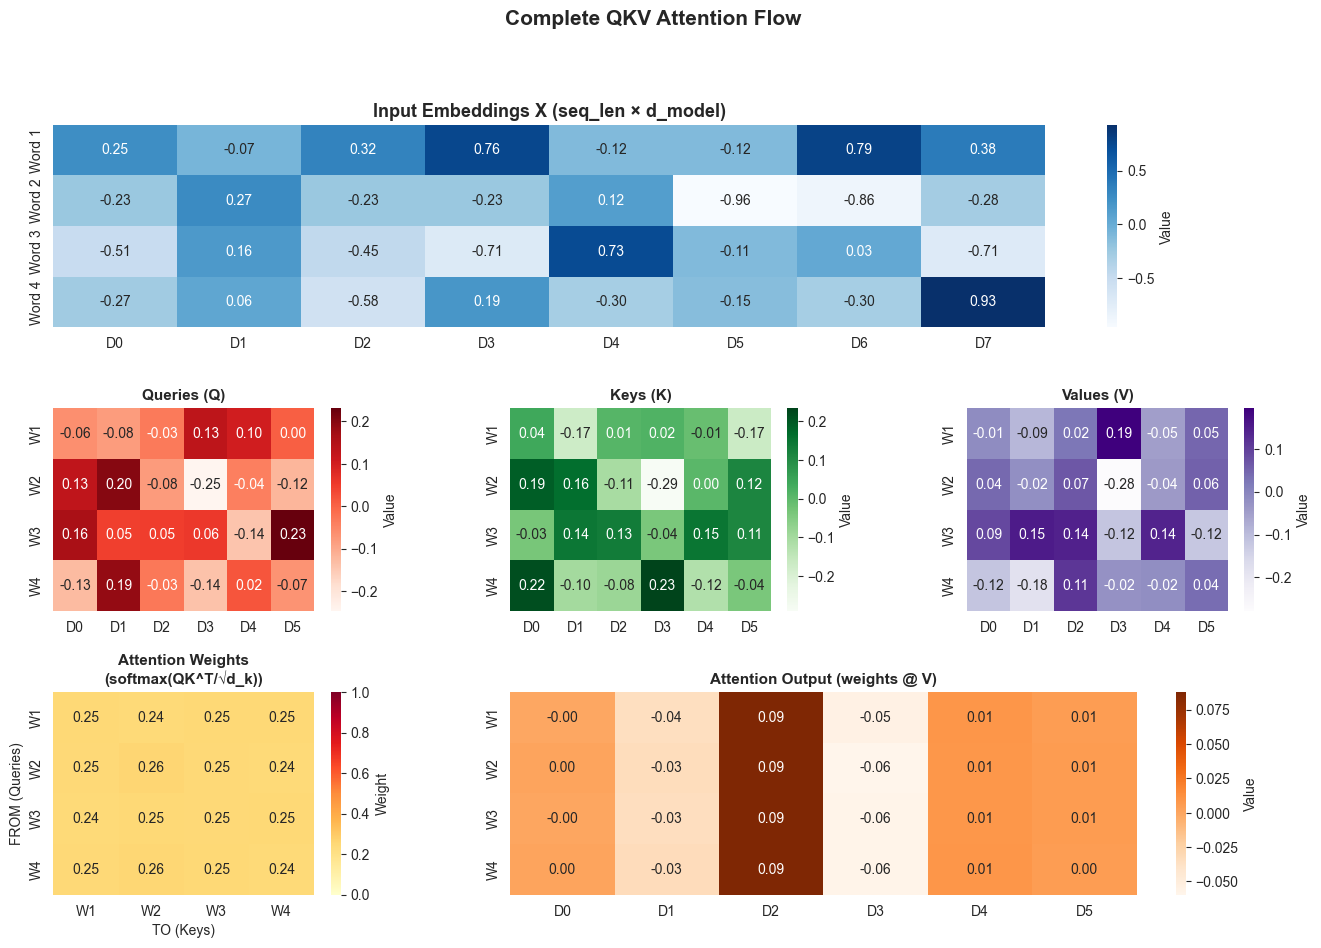


📊 Understanding the Flow:
1. Input X is projected to Q, K, V using learned weights
2. Q and K compute attention weights (who attends to whom)
3. Weights are applied to V to get the final output
4. Each word's output is a weighted combination of all values


In [11]:
# Comprehensive visualization
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.4)

# Input embeddings
ax = fig.add_subplot(gs[0, :])
sns.heatmap(X, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=[f'D{i}' for i in range(d_model)],
            yticklabels=[f'Word {i+1}' for i in range(seq_len)],
            cbar_kws={'label': 'Value'}, ax=ax)
ax.set_title('Input Embeddings X (seq_len × d_model)', fontsize=13, fontweight='bold')

# Q, K, V projections
Q_proj = X @ attention.W_Q
K_proj = X @ attention.W_K
V_proj = X @ attention.W_V

for idx, (proj, name, cmap) in enumerate([(Q_proj, 'Queries (Q)', 'Reds'),
                                             (K_proj, 'Keys (K)', 'Greens'),
                                             (V_proj, 'Values (V)', 'Purples')]):
    ax = fig.add_subplot(gs[1, idx])
    sns.heatmap(proj, annot=True, fmt='.2f', cmap=cmap,
                xticklabels=[f'D{i}' for i in range(proj.shape[1])],
                yticklabels=[f'W{i+1}' for i in range(seq_len)],
                cbar_kws={'label': 'Value'}, ax=ax)
    ax.set_title(name, fontsize=11, fontweight='bold')

# Attention weights
ax = fig.add_subplot(gs[2, 0])
sns.heatmap(weights, annot=True, fmt='.2f', cmap='YlOrRd',
            xticklabels=[f'W{i+1}' for i in range(seq_len)],
            yticklabels=[f'W{i+1}' for i in range(seq_len)],
            cbar_kws={'label': 'Weight'}, vmin=0, vmax=1, ax=ax)
ax.set_xlabel('TO (Keys)')
ax.set_ylabel('FROM (Queries)')
ax.set_title('Attention Weights\n(softmax(QK^T/√d_k))', fontsize=11, fontweight='bold')

# Output
ax = fig.add_subplot(gs[2, 1:])
sns.heatmap(output, annot=True, fmt='.2f', cmap='Oranges',
            xticklabels=[f'D{i}' for i in range(output.shape[1])],
            yticklabels=[f'W{i+1}' for i in range(seq_len)],
            cbar_kws={'label': 'Value'}, ax=ax)
ax.set_title('Attention Output (weights @ V)', fontsize=11, fontweight='bold')

plt.suptitle('Complete QKV Attention Flow', fontsize=15, fontweight='bold', y=0.995)
plt.show()

print("\n📊 Understanding the Flow:")
print("1. Input X is projected to Q, K, V using learned weights")
print("2. Q and K compute attention weights (who attends to whom)")
print("3. Weights are applied to V to get the final output")
print("4. Each word's output is a weighted combination of all values")

## Key Insights About QKV

### 1. Why Separate Q, K, V?

**Flexibility**: Allows different aspects of the same word to be used for:
- **Querying** (what it needs)
- **Matching** (what it offers)
- **Contributing** (what it passes along)

**Example - The word "cat" in "The cat sat"**:
- **As Query**: "cat" looking for verbs (what did the cat do?)
- **As Key**: "cat" advertising itself as a noun/subject
- **As Value**: Full meaning of "cat" to be incorporated

### 2. Learned, Not Fixed

- W_Q, W_K, W_V are **learned during training**
- The model learns optimal ways to transform embeddings
- Different tasks learn different projections

### 3. Dimensionality

- Typically: d_k = d_v = d_model / num_heads
- This allows efficient multi-head attention (coming next!)
- Common: d_model=512, d_k=d_v=64 (for 8 heads)

### 4. Computational Cost

```
For sequence length N and dimension d:

Projections: O(N × d²)
  Q = X @ W_Q  (N×d) @ (d×d) = O(Nd²)
  K = X @ W_K  (similar)
  V = X @ W_V  (similar)

Attention: O(N²d)
  QK^T: (N×d) @ (d×N) = O(N²d)
  softmax: O(N²)
  @ V: (N×N) @ (N×d) = O(N²d)

Total: O(N²d + Nd²)
```

For long sequences (N >> d), the O(N²d) attention dominates!

---

# Part 5: Self-Attention

## What is Self-Attention?

**Self-attention** means each word attends to **all words in the same sequence** (including itself).

### The Key Difference

**Cross-Attention** (seq2seq with attention):
```
Encoder outputs: [h₁, h₂, h₃, h₄]  (English)
Decoder state: d₁                   (French)

d₁ attends to [h₁, h₂, h₃, h₄]
↑
Attending to a DIFFERENT sequence
```

**Self-Attention** (transformers):
```
Sequence: [word₁, word₂, word₃, word₄]

word₁ attends to [word₁, word₂, word₃, word₄]
word₂ attends to [word₁, word₂, word₃, word₄]
word₃ attends to [word₁, word₂, word₃, word₄]
word₄ attends to [word₁, word₂, word₃, word₄]
↑
Each word attends to the SAME sequence (including itself)
```

## Why Self-Attention?

**Goal**: Let each word gather information from all other words in the sentence.

**Example**: "The cat sat on the mat"
- **"sat"** can attend to **"cat"** (who sat?)
- **"sat"** can attend to **"mat"** (sat where?)
- **"cat"** can attend to **"The"** (which cat?)

Each word becomes **context-aware** by looking at its neighbors!

## Self-Attention: A Concrete Example

Let's process a real sentence with self-attention.

In [12]:
# Example sentence
sentence = "The cat sat"
words = sentence.split()
seq_len = len(words)

print(f"Sentence: '{sentence}'")
print(f"Words: {words}")
print(f"Sequence length: {seq_len}")
print()

# Create simple embeddings (normally from embedding layer)
# We'll use distinct patterns so we can interpret results
d_model = 8
np.random.seed(42)

# Create embeddings that are somewhat distinct
embeddings = np.random.randn(seq_len, d_model) * 0.3
embeddings[0] += np.array([1, 0, 0, 0, 0, 0, 0, 0])  # "The"
embeddings[1] += np.array([0, 1, 0, 0, 0, 0, 0, 0])  # "cat"
embeddings[2] += np.array([0, 0, 1, 0, 0, 0, 0, 0])  # "sat"

print("Word Embeddings:")
for i, word in enumerate(words):
    print(f"  {word:5s}: {embeddings[i][:4]}... (showing first 4 dims)")
print()

# Apply self-attention
print("="*70)
print("Applying Self-Attention...")
print("="*70)

attention_layer = AttentionQKV(d_model=d_model, d_k=d_model, d_v=d_model)
output, weights = attention_layer.forward(embeddings)

print("\n" + "="*70)

Sentence: 'The cat sat'
Words: ['The', 'cat', 'sat']
Sequence length: 3

Word Embeddings:
  The  : [ 1.14901425 -0.04147929  0.19430656  0.45690896]... (showing first 4 dims)
  cat  : [-0.14084232  1.16276801 -0.13902531 -0.13971893]... (showing first 4 dims)
  sat  : [-0.30384934  0.0942742   0.72759278 -0.42369111]... (showing first 4 dims)

Applying Self-Attention...
Initialized Attention:
  Input dimension (d_model): 8
  Query/Key dimension (d_k): 8
  Value dimension (d_v): 8
  Parameters: 192

Projections:
  X shape: (3, 8)
  Q shape: (3, 8)
  K shape: (3, 8)
  V shape: (3, 8)
Step 1: Compute scores (Q @ K^T)
  Q shape: (3, 8), K shape: (3, 8)
  Scores shape: (3, 3)
  Scores range: [-0.08, 0.14]

Step 2: Scale by √d_k = √8 = 2.83
  Scaled scores range: [-0.03, 0.05]

Step 3: Apply softmax to get weights
  Weights shape: (3, 3)
  Weights sum (per row): [1. 1. 1.]
  (Each row sums to 1.0 ✓)

Step 4: Weighted average (weights @ V)
  V shape: (3, 8)
  Output shape: (3, 8)



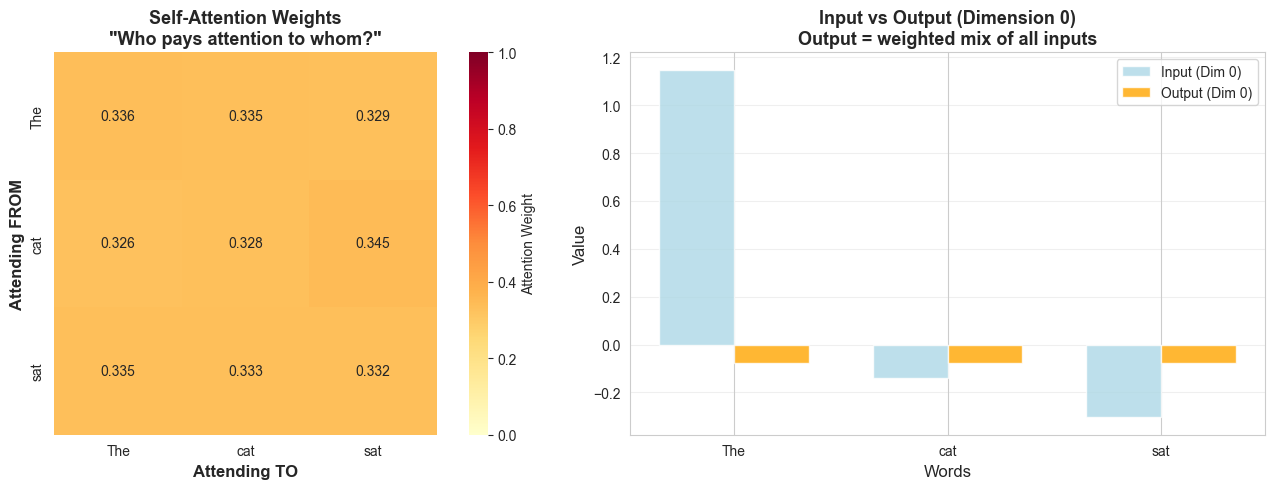


💡 Interpreting the Heatmap:

Row 1 ('The'):
  Attends to 'The' with weight 0.336
  Attends to 'cat' with weight 0.335
  Attends to 'sat' with weight 0.329

Row 2 ('cat'):
  Attends to 'The' with weight 0.326
  Attends to 'cat' with weight 0.328
  Attends to 'sat' with weight 0.345

Notice: Each word can attend to ALL words, including itself!


In [13]:
# Visualize self-attention weights
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LEFT: Attention weights
ax = axes[0]
sns.heatmap(weights, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=words, yticklabels=words,
            cbar_kws={'label': 'Attention Weight'},
            vmin=0, vmax=1, ax=ax, square=True)
ax.set_xlabel('Attending TO', fontsize=12, fontweight='bold')
ax.set_ylabel('Attending FROM', fontsize=12, fontweight='bold')
ax.set_title('Self-Attention Weights\n"Who pays attention to whom?"', 
             fontsize=13, fontweight='bold')

# Add interpretation
for i in range(len(words)):
    for j in range(len(words)):
        if weights[i, j] > 0.4:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, 
                                       fill=False, edgecolor='blue', linewidth=3))

# RIGHT: Output comparison
ax = axes[1]
x_pos = np.arange(len(words))
width = 0.35

# Compare first dimension of input vs output
input_dim0 = embeddings[:, 0]
output_dim0 = output[:, 0]

ax.bar(x_pos - width/2, input_dim0, width, label='Input (Dim 0)', alpha=0.8, color='lightblue')
ax.bar(x_pos + width/2, output_dim0, width, label='Output (Dim 0)', alpha=0.8, color='orange')
ax.set_xlabel('Words', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.set_title('Input vs Output (Dimension 0)\nOutput = weighted mix of all inputs', 
             fontsize=13, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(words)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n💡 Interpreting the Heatmap:")
print(f"\nRow 1 ('{words[0]}'):")
for j, word in enumerate(words):
    print(f"  Attends to '{word}' with weight {weights[0,j]:.3f}")

print(f"\nRow 2 ('{words[1]}'):")
for j, word in enumerate(words):
    print(f"  Attends to '{word}' with weight {weights[1,j]:.3f}")

print("\nNotice: Each word can attend to ALL words, including itself!")

---

# Part 6: Attention Masks

## Why Masking is Required

Masking is a critical concept in attention mechanisms. Let me explain why it's necessary from first principles.

### The Core Problem

Attention mechanisms compute relationships between all positions in a sequence. By default, every word can attend to every other word. But there are situations where this is either:
1. **Meaningless** (attending to padding)
2. **Cheating** (attending to future tokens)

Let me break down both cases:

---

## Problem 1: Padding Masks - Dealing with Different Length Sequences

### The Issue

In practice, sentences have different lengths:
- Sentence A: "The cat sat" (3 words)
- Sentence B: "I love machine learning models" (5 words)

But neural networks need fixed-size inputs for batch processing. So we pad shorter sequences:

```
Batch:
  [The, cat, sat, PAD, PAD]      ← padded to length 5
  [I, love, machine, learning, models]
```

### What Happens Without Padding Mask?

Without masking, the attention mechanism treats `[PAD]` tokens as real words:

```
Attention weights for "cat":
  "The"  : 0.25
  "cat"  : 0.20
  "sat"  : 0.30
  [PAD]  : 0.15  ← PROBLEM! Attending to meaningless padding
  [PAD]  : 0.10  ← PROBLEM!
```

**Problems:**
- ❌ Attention "wastes" probability mass on meaningless padding
- ❌ Padding tokens get incorporated into output representations
- ❌ Model learns spurious patterns from padding
- ❌ Different amounts of padding → different attention patterns (bad!)

### Solution: Padding Mask

We create a mask that says "Don't attend to padding":

```
Mask:  [1, 1, 1, 0, 0]  # 1 = can attend, 0 = mask out
```

After masking, attention weights:
```
"The"  : 0.30  ← Renormalized (only real words)
"cat"  : 0.25
"sat"  : 0.45
[PAD]  : 0.00  ← Masked out!
[PAD]  : 0.00  ← Masked out!
```

Now the model only attends to real words.

---

## Problem 2: Causal Masks - Preventing "Looking into the Future"

### The Issue

In autoregressive generation (like GPT), the model generates text one token at a time:

```
Generating: "The cat sat on the mat"

Step 1: Given nothing    → predict "The"
Step 2: Given "The"      → predict "cat"
Step 3: Given "The cat"  → predict "sat"
...
```

### What Happens Without Causal Mask?

During training, we have the full sentence. Without masking, when predicting "cat", the model could cheat by looking at future words:

```
Training scenario (without causal mask):
Position 2: Predicting "cat"
  Can attend to: [The, cat, sat, on, the, mat]
                      ↑    ↑↑↑↑↑↑↑↑↑↑↑↑
                      |    CHEATING! Sees future words!
                  predicting
```

**Problems:**
- ❌ Model learns to "cheat" by looking at answers during training
- ❌ At generation time (inference), future words don't exist → model fails
- ❌ Training vs inference mismatch → poor performance

### Solution: Causal Mask (Look-Ahead Mask)

We create a mask that enforces: **Position i can only attend to positions ≤ i**

```
Causal Mask (lower triangular):
     The  cat  sat  on  the  mat
The   1    0    0   0    0    0   ← "The" can only see "The"
cat   1    1    0   0    0    0   ← "cat" can see "The, cat"
sat   1    1    1   0    0    0   ← "sat" can see "The, cat, sat"
on    1    1    1   1    0    0
the   1    1    1   1    1    0
mat   1    1    1   1    1    1
```

Now:
- When predicting "cat" (position 2), can only see: "The"
- When predicting "sat" (position 3), can only see: "The cat"
- **No cheating allowed!**

---

## How Masking Works Technically

The key is **when** we apply the mask:

```python
# Step 1: Compute attention scores
scores = Q @ K.T / sqrt(d_k)
# scores[i,j] = how much position i wants to attend to position j

# Step 2: Apply mask BEFORE softmax
masked_scores = where(mask == 0, -∞, scores)
# Set masked positions to -∞

# Step 3: Softmax
weights = softmax(masked_scores)
# exp(-∞) = 0, so masked positions get zero weight!
```

### Why -∞?
- Before softmax, scores can be any value
- `exp(-∞) = 0`
- After softmax normalization, masked positions have exactly 0 weight
- Masked positions contribute nothing to the output

---

## Visual Comparison

### Without Mask (Problem)

Attention: Every word can see everything
```
The  →  [The, cat, sat, PAD, PAD]
cat  →  [The, cat, sat, PAD, PAD]  ← Seeing padding!
sat  →  [The, cat, sat, PAD, PAD]
```

### With Padding Mask (Solution)

Attention: Words can only see real words
```
The  →  [The, cat, sat]  ← PAD masked out
cat  →  [The, cat, sat]
sat  →  [The, cat, sat]
```

### With Causal Mask (Solution for Generation)

Attention: Words can only see past and present
```
The  →  [The]                    ← Can't see future
cat  →  [The, cat]
sat  →  [The, cat, sat]
```

---

## Real-World Impact

**Without proper masking:**
- Translation models would attend to padding → worse translations
- GPT models would cheat during training → fail at generation
- BERT models (bidirectional) don't need causal masks, but still need padding masks

**With masking:**
- ✅ Models learn correct patterns
- ✅ Training matches inference conditions
- ✅ No spurious correlations from padding
- ✅ Proper autoregressive behavior

---

## Summary

Masking is required because:

1. **Padding Mask**: Prevents attention to meaningless padding tokens
   - Keeps attention focused on real content
   - Ensures consistent behavior regardless of sequence length

2. **Causal Mask**: Prevents "looking into the future" during training
   - Enforces autoregressive constraint: predict next token using only past
   - Ensures training matches generation conditions

Without masking, attention mechanisms would:
- Learn wrong patterns from padding
- Cheat during training
- Fail during generation

**The masks are simple (just 0s and 1s), but they're essential for making attention mechanisms work correctly in practice!**

---



## Padding Mask

Sequence: ['The', 'cat', 'sat', PAD, PAD]
Valid tokens: 3
Total length: 5

Padding Mask:
[[1 1 1 0 0]
 [1 1 1 0 0]
 [1 1 1 0 0]
 [1 1 1 0 0]
 [1 1 1 0 0]]

1 = can attend, 0 = masked (padding)


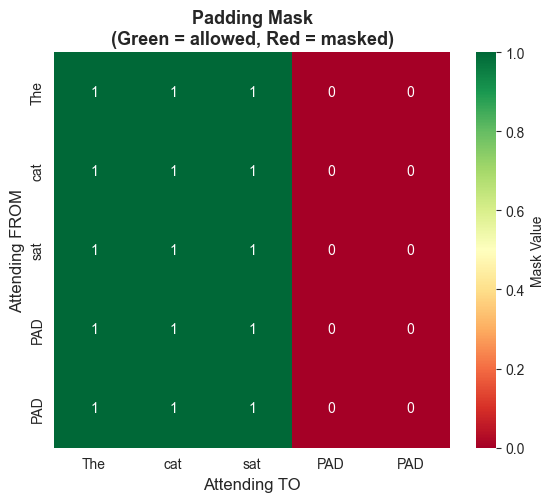


💡 Key Insight:
All tokens (including PAD) can only attend to valid tokens.
PAD tokens are ignored in attention computation.


In [14]:
def create_padding_mask(seq_len, valid_len):
    """
    Create a padding mask.
    
    Args:
        seq_len: Total sequence length (including padding)
        valid_len: Number of valid (non-padding) tokens
    
    Returns:
        mask: Binary mask, shape (seq_len, seq_len)
              1 = valid, 0 = masked (padding)
    """
    mask = np.zeros((seq_len, seq_len))
    mask[:, :valid_len] = 1  # Can attend to valid tokens
    return mask

# Example: sequence of length 5, but only first 3 tokens are valid
seq_len = 5
valid_len = 3

padding_mask = create_padding_mask(seq_len, valid_len)

print(f"Sequence: ['The', 'cat', 'sat', PAD, PAD]")
print(f"Valid tokens: {valid_len}")
print(f"Total length: {seq_len}")
print(f"\nPadding Mask:")
print(padding_mask.astype(int))
print("\n1 = can attend, 0 = masked (padding)")

# Visualize
plt.figure(figsize=(6, 5))
sns.heatmap(padding_mask, annot=True, fmt='.0f', cmap='RdYlGn',
            xticklabels=['The', 'cat', 'sat', 'PAD', 'PAD'],
            yticklabels=['The', 'cat', 'sat', 'PAD', 'PAD'],
            cbar_kws={'label': 'Mask Value'},
            vmin=0, vmax=1, square=True)
plt.xlabel('Attending TO', fontsize=12)
plt.ylabel('Attending FROM', fontsize=12)
plt.title('Padding Mask\n(Green = allowed, Red = masked)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 Key Insight:")
print("All tokens (including PAD) can only attend to valid tokens.")
print("PAD tokens are ignored in attention computation.")

## Causal Mask (Look-Ahead Mask)

Sequence length: 5

Causal Mask:
[[1 0 0 0 0]
 [1 1 0 0 0]
 [1 1 1 0 0]
 [1 1 1 1 0]
 [1 1 1 1 1]]

1 = can attend, 0 = masked (future)


/var/folders/rg/q149fzx17hbck29h_fn4xgpc0000gn/T/ipykernel_65607/2261966005.py:65: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/Users/chaitanya/Development/ai-learning/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


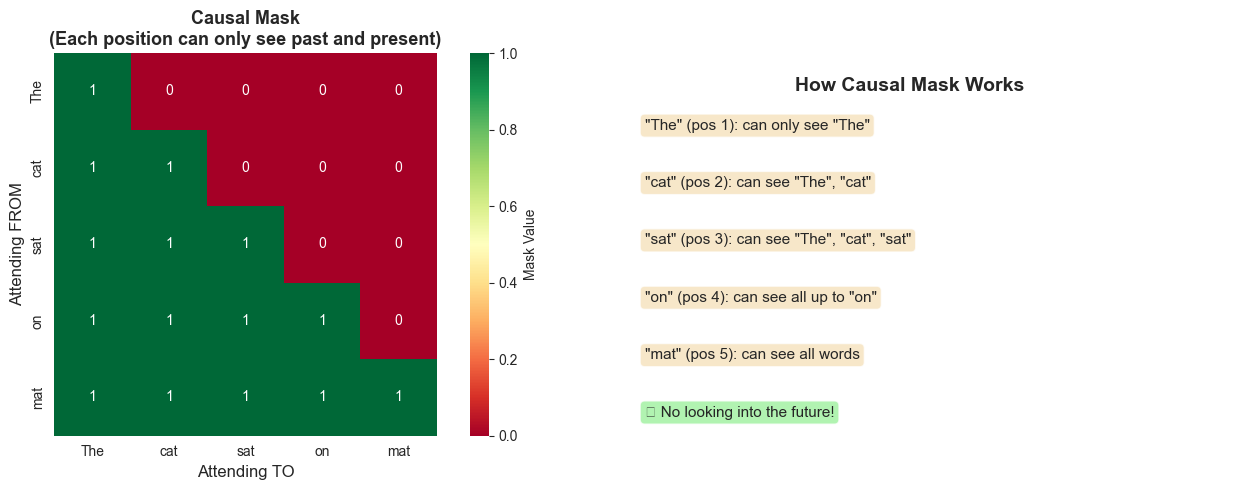


💡 Why Causal Mask?
Used in autoregressive models (GPT, language generation)
Ensures model only uses past context to predict next token
Critical for generation: can't cheat by looking at answers!


In [15]:
def create_causal_mask(seq_len):
    """
    Create a causal (look-ahead) mask.
    
    Prevents attending to future positions.
    
    Args:
        seq_len: Sequence length
    
    Returns:
        mask: Lower triangular matrix
              1 = can attend, 0 = masked (future)
    """
    # Lower triangular matrix (includes diagonal)
    mask = np.tril(np.ones((seq_len, seq_len)))
    return mask

# Example
seq_len = 5
causal_mask = create_causal_mask(seq_len)

print(f"Sequence length: {seq_len}")
print(f"\nCausal Mask:")
print(causal_mask.astype(int))
print("\n1 = can attend, 0 = masked (future)")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LEFT: Causal mask
ax = axes[0]
words_example = ['The', 'cat', 'sat', 'on', 'mat']
sns.heatmap(causal_mask, annot=True, fmt='.0f', cmap='RdYlGn',
            xticklabels=words_example, yticklabels=words_example,
            cbar_kws={'label': 'Mask Value'},
            vmin=0, vmax=1, square=True, ax=ax)
ax.set_xlabel('Attending TO', fontsize=12)
ax.set_ylabel('Attending FROM', fontsize=12)
ax.set_title('Causal Mask\n(Each position can only see past and present)', 
             fontsize=13, fontweight='bold')

# RIGHT: Interpretation
ax = axes[1]
ax.text(0.5, 0.9, 'How Causal Mask Works', 
        ha='center', fontsize=14, fontweight='bold',
        transform=ax.transAxes)

interpretations = [
    (0.8, '"The" (pos 1): can only see "The"'),
    (0.65, '"cat" (pos 2): can see "The", "cat"'),
    (0.50, '"sat" (pos 3): can see "The", "cat", "sat"'),
    (0.35, '"on" (pos 4): can see all up to "on"'),
    (0.20, '"mat" (pos 5): can see all words'),
    (0.05, '✓ No looking into the future!'),
]

for y, text in interpretations:
    ax.text(0.1, y, text, fontsize=11, transform=ax.transAxes,
            bbox=dict(boxstyle='round', facecolor='wheat' if '✓' not in text else 'lightgreen', alpha=0.7))

ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.axis('off')

plt.tight_layout()
plt.show()

print("\n💡 Why Causal Mask?")
print("Used in autoregressive models (GPT, language generation)")
print("Ensures model only uses past context to predict next token")
print("Critical for generation: can't cheat by looking at answers!")

## Applying Masks in Attention

Initialized Attention:
  Input dimension (d_model): 6
  Query/Key dimension (d_k): 6
  Value dimension (d_v): 6
  Parameters: 108
Comparing: No Mask vs Causal Mask

1. WITHOUT MASK (can see all positions):

Projections:
  X shape: (4, 6)
  Q shape: (4, 6)
  K shape: (4, 6)
  V shape: (4, 6)
Step 1: Compute scores (Q @ K^T)
  Q shape: (4, 6), K shape: (4, 6)
  Scores shape: (4, 4)
  Scores range: [-0.04, 0.04]

Step 2: Scale by √d_k = √6 = 2.45
  Scaled scores range: [-0.02, 0.02]

Step 3: Apply softmax to get weights
  Weights shape: (4, 4)
  Weights sum (per row): [1. 1. 1. 1.]
  (Each row sums to 1.0 ✓)

Step 4: Weighted average (weights @ V)
  V shape: (4, 6)
  Output shape: (4, 6)


2. WITH CAUSAL MASK (can only see past):

Projections:
  X shape: (4, 6)
  Q shape: (4, 6)
  K shape: (4, 6)
  V shape: (4, 6)
Step 1: Compute scores (Q @ K^T)
  Q shape: (4, 6), K shape: (4, 6)
  Scores shape: (4, 4)
  Scores range: [-0.04, 0.04]

Step 2: Scale by √d_k = √6 = 2.45
  Scaled scores range

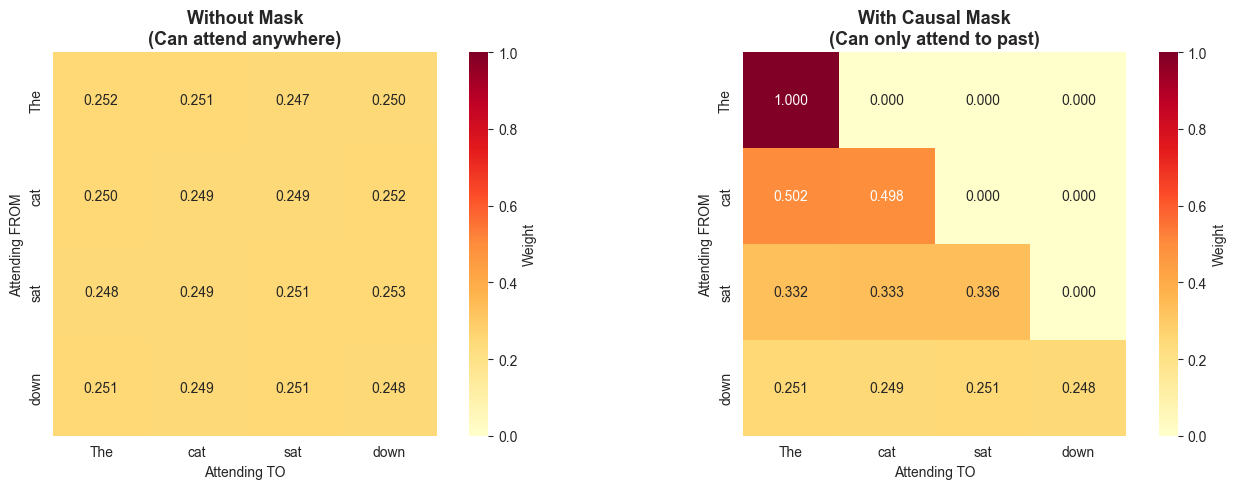


💡 Notice:
With causal mask, upper triangle is all zeros (no future attention)!


In [16]:
# Demonstrate masked attention
seq_len = 4
d_model = 6

# Create input
np.random.seed(42)
X = np.random.randn(seq_len, d_model) * 0.5
words = ['The', 'cat', 'sat', 'down']

# Create attention layer
attn = AttentionQKV(d_model=d_model, d_k=d_model, d_v=d_model)

print("Comparing: No Mask vs Causal Mask")
print("="*70)

# Without mask
print("\n1. WITHOUT MASK (can see all positions):")
output_no_mask, weights_no_mask = attn.forward(X, mask=None)

# With causal mask
causal_mask = create_causal_mask(seq_len)
print("\n" + "="*70)
print("\n2. WITH CAUSAL MASK (can only see past):")
output_causal, weights_causal = attn.forward(X, mask=causal_mask)

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LEFT: No mask
ax = axes[0]
sns.heatmap(weights_no_mask, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=words, yticklabels=words,
            cbar_kws={'label': 'Weight'}, vmin=0, vmax=1, square=True, ax=ax)
ax.set_xlabel('Attending TO')
ax.set_ylabel('Attending FROM')
ax.set_title('Without Mask\n(Can attend anywhere)', fontsize=13, fontweight='bold')

# RIGHT: Causal mask
ax = axes[1]
sns.heatmap(weights_causal, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=words, yticklabels=words,
            cbar_kws={'label': 'Weight'}, vmin=0, vmax=1, square=True, ax=ax)
ax.set_xlabel('Attending TO')
ax.set_ylabel('Attending FROM')
ax.set_title('With Causal Mask\n(Can only attend to past)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n💡 Notice:")
print("With causal mask, upper triangle is all zeros (no future attention)!")

---

# Part 7: Multi-Head Attention

## The Motivation

**Problem with Single Attention Head**:
- Only one way to attend to other words
- One set of learned Q, K, V weights
- Limited expressiveness

**Example**: In "The cat sat on the mat"
- Might want to attend to **syntax** (subject-verb relationship)
- AND also attend to **semantics** (location information)
- AND also attend to **nearby context**

**Solution**: Use multiple attention heads in parallel!

## What is Multi-Head Attention?

**Idea**: Run multiple attention mechanisms in parallel, each with different learned weights.

```
Input X
  ↓
  ├→ Head 1 (W_Q¹, W_K¹, W_V¹) → output₁
  ├→ Head 2 (W_Q², W_K², W_V²) → output₂
  ├→ Head 3 (W_Q³, W_K³, W_V³) → output₃
  └→ ...
  
Concatenate [output₁, output₂, output₃, ...]
  ↓
Linear projection W_O
  ↓
Final output
```

Each head learns to focus on different aspects of the relationships!

## The Math

**Single-Head Attention**:
```
head = Attention(XW_Q, XW_K, XW_V)
```

**Multi-Head Attention** (h heads):
```
head_i = Attention(XW_Q^i, XW_K^i, XW_V^i)  for i = 1 to h

MultiHead(X) = Concat(head_1, ..., head_h) W_O
```

---

## Understanding Multi-Head Dimensions

### The Core Idea: Splitting vs Single-Head

Instead of doing one big attention with the full embedding dimension, we **split it into multiple smaller parallel attentions**.

```
Single-Head (hypothetical):
  Input: d_model (e.g., 768-dim)
         ↓
  Attention with full 768 dimensions
         ↓
  Output: 768-dim

Multi-Head (actual with h=12 heads):
  Input: d_model = 768-dim
         ↓
  Split into 12 heads of 64-dim each
         ↓
  Head 1: Attention on 64-dim slice
  Head 2: Attention on 64-dim slice
  ...
  Head 12: Attention on 64-dim slice
         ↓
  Concatenate: 12 × 64 = 768-dim
         ↓
  Project with W_O: 768 → 768
         ↓
  Output: 768-dim
```

### Why d_k = d_v = d_model / h?

This formula **splits the embedding dimension evenly** across all heads:

```
d_model = 768  (total embedding dimension)
h = 12         (number of attention heads)

d_k = d_v = d_model / h = 768 / 12 = 64 dimensions per head
```

**Key insight**: When you concatenate all heads back together:
```
12 heads × 64 dims/head = 768 dimensions (back to d_model!)
```

This ensures the output dimension matches the input dimension, allowing us to stack attention layers.

### Parameter Count Breakdown

Let's carefully count the parameters in multi-head attention.

**For ONE head (example: head 1):**

Each head needs 3 projection matrices to create Q, K, V from the input:
- **W_Q**: Projects input from d_model → d_k = `768 → 64`
  - Parameters: `768 × 64 = 49,152`
- **W_K**: Projects input from d_model → d_k = `768 → 64`
  - Parameters: `768 × 64 = 49,152`
- **W_V**: Projects input from d_model → d_v = `768 → 64`
  - Parameters: `768 × 64 = 49,152`

**Total per head**: `768 × 64 × 3 = 147,456 ≈ 147K parameters`

**For ALL 12 heads:**

```
147K parameters/head × 12 heads = 1,769,472 ≈ 1.7M parameters
```

**Plus the output projection W_O:**
- After concatenating all heads: `12 × 64 = 768` dimensions
- W_O projects: `768 → 768`
- Parameters: `768 × 768 = 589,824 ≈ 590K`

**Total for multi-head attention block:**
```
1.7M (Q,K,V for all heads) + 590K (output projection) ≈ 2.3M parameters
```

### Example (GPT-2 Small)

```
d_model = 768
h = 12 heads
d_k = d_v = 768 / 12 = 64 per head

Per head: 768 × 64 × 3 = 147,456 params
All heads: 147K × 12 = 1,769,472 params
Output projection: 768 × 768 = 589,824 params
────────────────────────────────────────
Total: ~2.36M parameters per attention layer
```

**Why this matters**: GPT-2 Small has 12 layers, so attention alone accounts for ~28M parameters!

---

**Key Takeaways**:
1. Each head works on a **smaller slice** (64-dim) of the full embedding (768-dim)
2. Heads run in **parallel** - different Q, K, V weights for each
3. Outputs are **concatenated** then **projected** to match d_model
4. This allows the model to attend to different aspects simultaneously (syntax, semantics, context, etc.)


## Implementation

In [17]:
class MultiHeadAttention:
    """
    Multi-Head Attention mechanism.
    """
    
    def __init__(self, d_model, num_heads):
        """
        Initialize multi-head attention.
        
        Args:
            d_model: Dimension of input/output
            num_heads: Number of attention heads
        """
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # Dimension per head
        
        # Separate Q, K, V weights for each head
        self.W_Q = [np.random.randn(d_model, self.d_k) * 0.1 for _ in range(num_heads)]
        self.W_K = [np.random.randn(d_model, self.d_k) * 0.1 for _ in range(num_heads)]
        self.W_V = [np.random.randn(d_model, self.d_k) * 0.1 for _ in range(num_heads)]
        
        # Output projection
        self.W_O = np.random.randn(d_model, d_model) * 0.1
        
        print(f"Initialized Multi-Head Attention:")
        print(f"  Input/Output dimension (d_model): {d_model}")
        print(f"  Number of heads: {num_heads}")
        print(f"  Dimension per head (d_k): {self.d_k}")
        print(f"  Parameters per head: {d_model * self.d_k * 3:,}")
        print(f"  Total parameters: {(d_model * self.d_k * 3 * num_heads + d_model * d_model):,}")
    
    def forward(self, X, mask=None, return_attention=False):
        """
        Forward pass.
        
        Args:
            X: Input, shape (seq_len, d_model)
            mask: Optional mask
            return_attention: Whether to return attention weights
        
        Returns:
            output: shape (seq_len, d_model)
            attention_weights: (if return_attention=True)
        """
        seq_len = X.shape[0]
        
        # Store outputs from each head
        head_outputs = []
        attention_weights_all = []
        
        # Process each head independently
        for i in range(self.num_heads):
            # Project to Q, K, V for this head
            Q = X @ self.W_Q[i]
            K = X @ self.W_K[i]
            V = X @ self.W_V[i]
            
            # Compute attention for this head
            head_output, attention_weights = scaled_dot_product_attention(Q, K, V, mask)
            
            head_outputs.append(head_output)
            attention_weights_all.append(attention_weights)
        
        # Concatenate all heads
        concat = np.concatenate(head_outputs, axis=-1)  # Shape: (seq_len, d_model)
        
        # Apply output projection
        output = concat @ self.W_O
        
        if return_attention:
            return output, attention_weights_all
        return output

print("✓ MultiHeadAttention class defined!")

✓ MultiHeadAttention class defined!


### Test Multi-Head Attention

In [18]:
# Create test input
seq_len = 4
d_model = 8
num_heads = 2

np.random.seed(42)
X = np.random.randn(seq_len, d_model) * 0.5
words = ['The', 'cat', 'sat', 'down']

print("Input:")
print(f"  Sequence: {words}")
print(f"  Shape: {X.shape}")
print()

# Create multi-head attention
print("="*70)
mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
print("="*70)

# Forward pass (suppress output from scaled_dot_product_attention)
import sys
from io import StringIO

old_stdout = sys.stdout
sys.stdout = StringIO()  # Redirect stdout

output, attention_weights = mha.forward(X, return_attention=True)

sys.stdout = old_stdout  # Restore stdout

print("\nOutput:")
print(f"  Shape: {output.shape}")
print(f"  (Same as input: {X.shape})")
print()
print(f"Number of attention heads: {len(attention_weights)}")
print(f"Each head's attention weights shape: {attention_weights[0].shape}")

Input:
  Sequence: ['The', 'cat', 'sat', 'down']
  Shape: (4, 8)

Initialized Multi-Head Attention:
  Input/Output dimension (d_model): 8
  Number of heads: 2
  Dimension per head (d_k): 4
  Parameters per head: 96
  Total parameters: 256

Output:
  Shape: (4, 8)
  (Same as input: (4, 8))

Number of attention heads: 2
Each head's attention weights shape: (4, 4)


### Visualize Multiple Heads

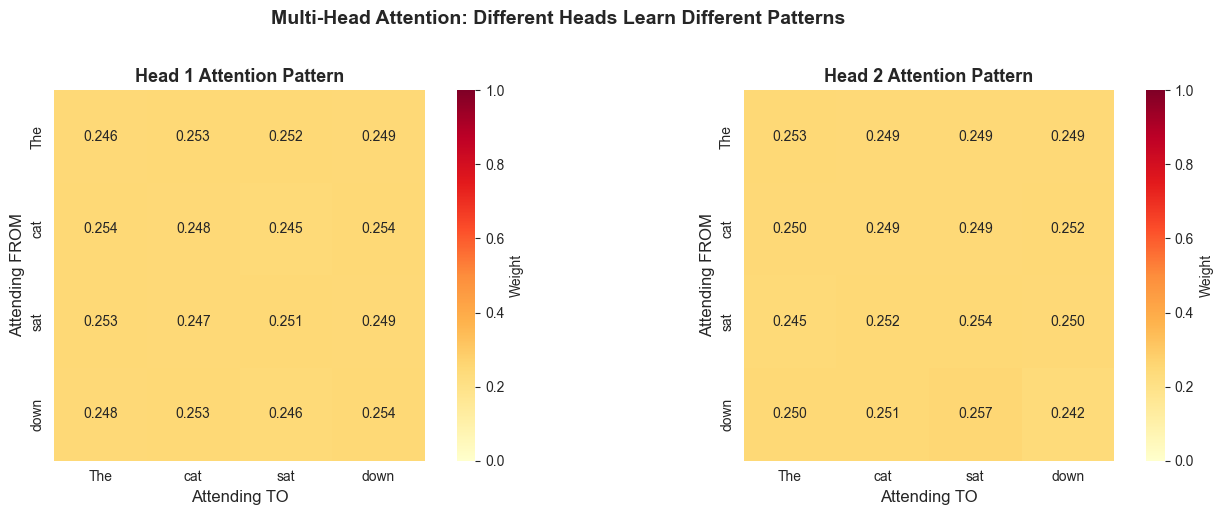


💡 Key Observation:
Each head has learned different attention patterns!

In practice (with training):
  - Head 1 might focus on syntax (subject-verb)
  - Head 2 might focus on semantics (word meanings)
  - Head 3 might focus on position (nearby words)
  - etc.

The model learns what each head should focus on during training!


In [19]:
# Visualize attention patterns from different heads
fig, axes = plt.subplots(1, num_heads, figsize=(7 * num_heads, 5))

if num_heads == 1:
    axes = [axes]

for i, ax in enumerate(axes):
    sns.heatmap(attention_weights[i], annot=True, fmt='.3f', cmap='YlOrRd',
                xticklabels=words, yticklabels=words,
                cbar_kws={'label': 'Weight'},
                vmin=0, vmax=1, square=True, ax=ax)
    ax.set_xlabel('Attending TO', fontsize=12)
    ax.set_ylabel('Attending FROM', fontsize=12)
    ax.set_title(f'Head {i+1} Attention Pattern', fontsize=13, fontweight='bold')

plt.suptitle('Multi-Head Attention: Different Heads Learn Different Patterns', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n💡 Key Observation:")
print("Each head has learned different attention patterns!")
print("\nIn practice (with training):")
print("  - Head 1 might focus on syntax (subject-verb)")
print("  - Head 2 might focus on semantics (word meanings)")
print("  - Head 3 might focus on position (nearby words)")
print("  - etc.")
print("\nThe model learns what each head should focus on during training!")

## Why Multi-Head Attention Works

### 1. Increased Expressiveness

**Single Head**: Only one way to compute relevance
```
Attention might learn: word1 → word2 (subject-verb)
But then it can't also learn: word1 → word3 (adjective-noun)
```

**Multiple Heads**: Can learn multiple relationship types
```
Head 1: Learns syntactic relationships
Head 2: Learns semantic relationships  
Head 3: Learns positional patterns
Head 4: Learns long-range dependencies
```

### 2. Ensemble Effect

- Multiple independent attention mechanisms
- Each head can specialize
- Final output combines all perspectives
- Reduces risk of missing important patterns

### 3. Computational Efficiency

**Surprising fact**: Multi-head is often FASTER than single-head!

Why?
```
Single head with d_model=512:
  Attention cost: O(N² × 512)

8 heads with d_k=64 each:
  Cost per head: O(N² × 64)
  Total: 8 × O(N² × 64) = O(N² × 512)
  Same asymptotic cost!
  
But: 8 smaller operations parallelize better on GPUs!
```

### 4. Different Types of Information

**Linguistic Research** shows heads learn:
- **Syntactic heads**: Track grammatical structure
- **Semantic heads**: Track meaning relationships
- **Positional heads**: Track relative positions
- **Rare word heads**: Focus on unusual tokens

Example from BERT:
- Head 8-10 in layer 5: Track subject-verb agreement
- Head 5-7 in layer 8: Track coreference ("he" refers to "John")
- Head 2 in layer 3: Attends to next word (position bias)

## Key Hyperparameters

**Trade-offs in choosing number of heads**:

```
Fewer heads (e.g., 1-4):
  ✓ Simpler model
  ✓ Fewer parameters
  ✗ Less expressiveness
  ✗ Might miss complex patterns

More heads (e.g., 8-16):
  ✓ More expressiveness
  ✓ Can learn diverse patterns
  ✗ More parameters
  ✗ Risk of redundancy

Typical choices:
  - GPT-2 small: 12 heads
  - BERT base: 12 heads
  - GPT-3: 96 heads (in large variant)
```

---

# Exercises

Test your understanding with these exercises!

## Exercise 1: Compute Attention Manually

**Task**: Given these simple inputs, compute attention weights by hand.

```python
Q = [[1, 0],
     [0, 1]]

K = [[1, 0],
     [0, 1]]

V = [[2, 0],
     [0, 2]]
```

**Steps**:
1. Compute scores: QK^T
2. Scale by √d_k
3. Apply softmax
4. Compute output: weights @ V

**Verify your answer by running the code below:**

In [20]:
# Exercise 1: Solution
Q_ex = np.array([[1, 0], [0, 1]])
K_ex = np.array([[1, 0], [0, 1]])
V_ex = np.array([[2, 0], [0, 2]])

output_ex, weights_ex = scaled_dot_product_attention(Q_ex, K_ex, V_ex)

print("\nAttention Weights:")
print(weights_ex)
print("\nAttention Output:")
print(output_ex)
print("\n💡 What do you notice about the diagonal pattern?")

Step 1: Compute scores (Q @ K^T)
  Q shape: (2, 2), K shape: (2, 2)
  Scores shape: (2, 2)
  Scores range: [0.00, 1.00]

Step 2: Scale by √d_k = √2 = 1.41
  Scaled scores range: [0.00, 0.71]

Step 3: Apply softmax to get weights
  Weights shape: (2, 2)
  Weights sum (per row): [1. 1.]
  (Each row sums to 1.0 ✓)

Step 4: Weighted average (weights @ V)
  V shape: (2, 2)
  Output shape: (2, 2)

Attention Weights:
[[0.66976155 0.33023845]
 [0.33023845 0.66976155]]

Attention Output:
[[1.3395231 0.6604769]
 [0.6604769 1.3395231]]

💡 What do you notice about the diagonal pattern?


## Exercise 2: Attention with Different Masks

**Task**: Create a mask that allows each word to attend to:
1. Itself only
2. Itself and the previous word
3. Itself and the next word

**Implement and visualize the results:**

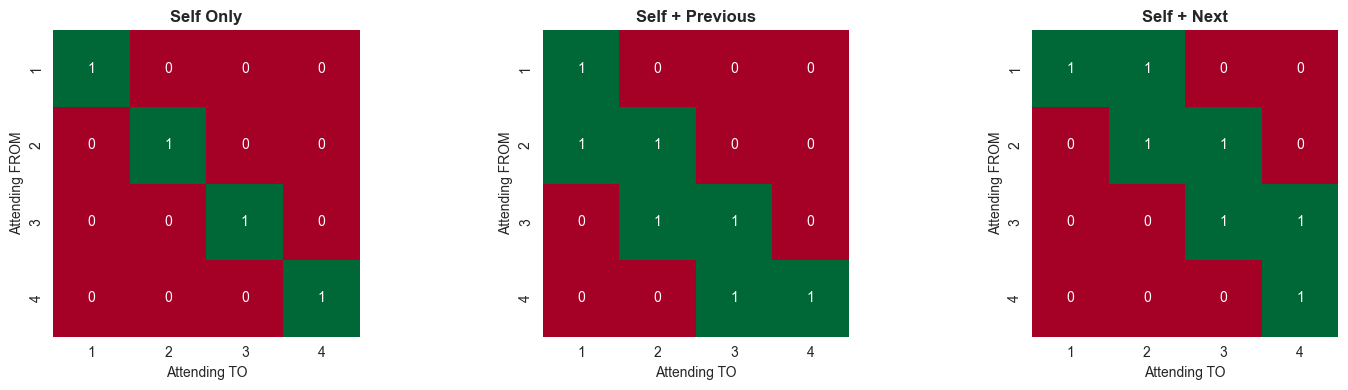

In [21]:
# Exercise 2: Solution template
seq_len = 4

# Mask 1: Self-only (diagonal)
mask_self = np.eye(seq_len)

# Mask 2: Self + previous (lower diagonal band)
mask_prev = np.tril(np.ones((seq_len, seq_len)), k=0) - np.tril(np.ones((seq_len, seq_len)), k=-2)

# Mask 3: Self + next (upper diagonal band)
mask_next = np.triu(np.ones((seq_len, seq_len)), k=0) - np.triu(np.ones((seq_len, seq_len)), k=2)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
masks = [mask_self, mask_prev, mask_next]
titles = ['Self Only', 'Self + Previous', 'Self + Next']

for ax, mask, title in zip(axes, masks, titles):
    sns.heatmap(mask, annot=True, fmt='.0f', cmap='RdYlGn',
                xticklabels=range(1, seq_len+1),
                yticklabels=range(1, seq_len+1),
                vmin=0, vmax=1, square=True, ax=ax,
                cbar=False)
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('Attending TO')
    ax.set_ylabel('Attending FROM')

plt.tight_layout()
plt.show()

## Exercise 3: Analyze Attention Patterns

**Task**: Given a sentence, analyze what makes sense for attention patterns.

**Sentence**: "The big red car drove fast"

**Questions**:
1. Which word should "drove" attend to most? Why?
2. Which word should "red" attend to most? Why?
3. Which word should "fast" attend to most? Why?

**Think about this, then check your reasoning below:**

### Exercise 3: Reasoning

**Answer 1**: "drove" should attend to **"car"** most
- Why? "car" is the subject performing the action
- This is a subject-verb relationship (syntax)

**Answer 2**: "red" should attend to **"car"** most
- Why? "red" is an adjective describing "car"
- This is an adjective-noun relationship (syntax)

**Answer 3**: "fast" should attend to **"drove"** most
- Why? "fast" is an adverb modifying "drove"
- This is an adverb-verb relationship (syntax)

**Key Insight**: Attention learns these syntactic and semantic relationships automatically during training!

## Exercise 4: Implement Simplified Multi-Head Attention

**Task**: Implement a simplified version with 2 heads, using the same Q, K, V for both heads but different output projections.

**Challenge**: Try to write this yourself before looking at the solution!

In [22]:
# Exercise 4: Solution
def simple_multihead_attention(X, num_heads=2):
    """
    Simplified multi-head attention.
    Uses same QKV for all heads, only output projections differ.
    """
    seq_len, d_model = X.shape
    d_k = d_model // num_heads
    
    # Single Q, K, V for all heads
    W_Q = np.random.randn(d_model, d_model) * 0.1
    W_K = np.random.randn(d_model, d_model) * 0.1
    W_V = np.random.randn(d_model, d_model) * 0.1
    
    Q = X @ W_Q
    K = X @ W_K
    V = X @ W_V
    
    # Split into heads
    Q_heads = Q.reshape(seq_len, num_heads, d_k)
    K_heads = K.reshape(seq_len, num_heads, d_k)
    V_heads = V.reshape(seq_len, num_heads, d_k)
    
    # Compute attention for each head
    outputs = []
    for h in range(num_heads):
        # Suppress output
        import sys
        from io import StringIO
        old_stdout = sys.stdout
        sys.stdout = StringIO()
        
        out, _ = scaled_dot_product_attention(
            Q_heads[:, h, :], 
            K_heads[:, h, :], 
            V_heads[:, h, :]
        )
        
        sys.stdout = old_stdout
        outputs.append(out)
    
    # Concatenate and project
    concat = np.concatenate(outputs, axis=-1)
    W_O = np.random.randn(d_model, d_model) * 0.1
    final_output = concat @ W_O
    
    return final_output

# Test it
X_test = np.random.randn(4, 8) * 0.5
output_test = simple_multihead_attention(X_test, num_heads=2)

print(f"Input shape: {X_test.shape}")
print(f"Output shape: {output_test.shape}")
print("\n✓ Exercise 4 complete!")

Input shape: (4, 8)
Output shape: (4, 8)

✓ Exercise 4 complete!


---

# Summary & Key Takeaways

## What We Learned

Congratulations! You've mastered the attention mechanism. Let's recap:

### 1. Why Attention? (Part 1)

**Problems with RNNs**:
- ✗ Sequential processing (slow)
- ✗ Information bottleneck (fixed-size context)
- ✗ Long-range dependencies (vanishing gradients)
- ✗ No selective focus

**Attention solves all of these**:
- ✓ Can be parallelized
- ✓ Direct access to all inputs
- ✓ No gradient degradation
- ✓ Learns what to focus on

### 2. Core Mechanism (Part 2-3)

**Attention is weighted averaging**:
```
output = Σ (weight_i × value_i)
```

**Scaled Dot-Product Attention**:
```
Attention(Q, K, V) = softmax(QK^T / √d_k) × V
```

**Four steps**:
1. Compute similarity scores (QK^T)
2. Scale by √d_k
3. Convert to probabilities (softmax)
4. Weighted average of values

### 3. Query, Key, Value (Part 4)

**Three different roles**:
- **Query (Q)**: "What am I looking for?"
- **Key (K)**: "What do I have to offer?"
- **Value (V)**: "What information do I contain?"

**Why separate**:
- More flexible than using same vector
- Can learn different transformations
- Enables rich relationships

### 4. Self-Attention (Part 5)

**Each word attends to all words**:
- Including itself!
- In the same sequence
- Enables context-aware representations

**Result**: Every word's representation incorporates information from the entire sequence.

### 5. Masks (Part 6)

**Two types**:
1. **Padding mask**: Ignore [PAD] tokens
2. **Causal mask**: Prevent looking at future (for generation)

**Applied before softmax**:
```
masked_scores = where(mask == 0, -∞, scores)
```

### 6. Multi-Head Attention (Part 7)

**Run multiple attention heads in parallel**:
- Each head learns different patterns
- More expressive
- Can capture diverse relationships

**Common setup**:
```
8-12 heads
d_k = d_model / num_heads
Total cost same as single head!
```

## The Big Picture

### How Attention Fits into Transformers

```
Transformer Architecture:

1. Input Embeddings
   ↓
2. Positional Encoding (tells position)
   ↓
3. Multi-Head Self-Attention ← We learned this!
   ↓
4. Add & Norm (residual + layer norm)
   ↓
5. Feed-Forward Network
   ↓
6. Add & Norm
   ↓
7. Repeat steps 3-6 many times (e.g., 12 layers)
   ↓
8. Output
```

**Attention is the core** that makes transformers work!

### From Attention to Modern LLMs

**The journey**:

1. **2017**: Transformer paper ("Attention Is All You Need")
   - Introduced multi-head self-attention
   - Beat RNNs on translation

2. **2018**: BERT (Bidirectional Encoder)
   - Used transformer encoders
   - Pre-training + fine-tuning paradigm

3. **2018**: GPT-1 (Autoregressive Decoder)
   - Used transformer decoders
   - Causal attention for generation

4. **2019-2020**: GPT-2, GPT-3
   - Scaled up massively
   - Emergent abilities

5. **2022-2023**: ChatGPT, GPT-4, Claude
   - Added RLHF (reinforcement learning from human feedback)
   - Conversational AI

**All built on attention!**

## Key Equations Reference

### Scaled Dot-Product Attention
```
Attention(Q, K, V) = softmax(QK^T / √d_k) × V
```

### Multi-Head Attention
```
head_i = Attention(Q W_Q^i, K W_K^i, V W_V^i)
MultiHead(Q,K,V) = Concat(head_1, ..., head_h) W_O
```

### Self-Attention (special case)
```
Q = K = V = X  (same sequence)
SelfAttention(X) = Attention(X, X, X)
```

### With Mask
```
scores = QK^T / √d_k
masked_scores = where(mask == 0, -∞, scores)
weights = softmax(masked_scores)
output = weights × V
```

## What's Next?

### You're Ready For:

**Next Notebook**: `03_transformer_architecture.ipynb`
- Complete transformer encoder and decoder
- Positional encoding
- Layer normalization
- Residual connections
- Training transformers

**Then**: Building GPT
- Decoder-only transformers
- Tokenization
- Training on text
- Text generation

### Further Reading

**Papers**:
1. "Attention Is All You Need" (Vaswani et al., 2017)
   - The original transformer paper
   - Highly readable!

2. "BERT: Pre-training of Deep Bidirectional Transformers" (Devlin et al., 2018)
   - Bidirectional attention
   - Pre-training paradigm

3. "Improving Language Understanding by Generative Pre-Training" (GPT-1)
   - Autoregressive transformers
   - The start of the GPT series

**Resources**:
- The Illustrated Transformer (Jay Alammar)
- Hugging Face Transformers documentation
- Stanford CS224N (NLP course)

### Skills You've Gained

✅ **Understanding**: Deep knowledge of how attention works

✅ **Implementation**: Built attention from scratch

✅ **Intuition**: Can reason about attention patterns

✅ **Foundation**: Ready for advanced architectures

You're now part of the small group of people who truly understand one of the most important algorithms in modern AI!

---

# Congratulations! 🎉

You've completed the attention mechanism notebook!

## What You Accomplished

- ✅ Understood why attention is necessary
- ✅ Learned the core attention mechanism
- ✅ Mastered Query, Key, Value
- ✅ Implemented self-attention
- ✅ Understood attention masks
- ✅ Built multi-head attention from scratch

## The Journey Continues

You've learned the **most important building block** of modern NLP. Everything else (GPT, BERT, ChatGPT, etc.) builds on this foundation.

**From here, you can**:
- Build complete transformers
- Train language models
- Understand research papers
- Implement state-of-the-art models

**The world of AI is now much more accessible to you!**

See you in the next notebook! 🚀